In [1]:
import os
import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import copy


%matplotlib notebook

In [6]:
working_directory = r"D:/Files_Reutlingen_Jenny/main_191023/_output_Spikesorting_29042021_spontaneous_spikesorting"

output_directory = r"D:/Files_Reutlingen_Jenny/main_191023/_output_Spikesorting_29042021_spontaneous_spikesorting/analysis_Paper"


df_directory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/REUTLINGEN_Paper"

os.chdir(df_directory)

In [7]:
os.chdir(working_directory)

In [8]:
filename= 'spontaneous'

In [5]:
overview_df.loc['filename']=filename
overview_df.loc[(overview_df['filename']==filename), 'loc']='Reutlingen'

NameError: name 'overview_df' is not defined

In [ ]:
overview_df

In [9]:
filelist = glob.glob('*.npy')

In [10]:
filelist

['spontaneous_DataFrame_dictionary.npy',
 'spontaneous_spiketrains_nested_per_channel_per_unit.npy',
 'spontaneous_spiketrains_per_channel.npy',
 'spontaneous_spiketrains_per_unit.npy',
 'spontaneous_spiketrains_per_unit.npy_SPADE_3.npy']

In [11]:
spike_dic_filename = glob.glob('*spiketrains_per_channel*')[0]


In [12]:
spike_dic_filename

'spontaneous_spiketrains_per_channel.npy'

In [13]:
spikedic_SC = np.load(spike_dic_filename, allow_pickle=True).item()


In [14]:
tick = 40
timelengthrecording_s = 300
#first_recording_timepoint = info_dic['first_recording_timepoint']
scale_factor_for_second = 1e-06


In [15]:
# cross this out if you want them in the original directory
os.chdir(output_directory)

In [16]:
 # create an array of the spikes in scale of seconds
active_channels = 0
spikedic_seconds = {}
for key in spikedic_SC:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_SC[key])>relevant_factor:
        sec_array = np.asarray(spikedic_SC[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

In [17]:
timelengthrecording_s*0.05



15.0

In [18]:
active_channels

230

In [19]:
# get a 1-D array with every detected spike
scale_factor_for_milisecond = 1e-03
full_spike_list = []
full_spike_list_seconds = []
for key in spikedic_SC:
    if len(spikedic_SC[key])>relevant_factor:
        x = list(np.asarray(spikedic_SC[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_SC[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
full_spikes = sorted(full_spike_list)
full_spikes_seconds = sorted(full_spike_list_seconds)

In [20]:
mean_fr_whole_recording = np.around((len(full_spikes_seconds) / timelengthrecording_s), 3)

In [21]:
mean_fr_whole_recording

792.127

In [22]:
 #define bins 
binsize = 0.005 #seconds
bins= np.arange(0, timelengthrecording_s+binsize, binsize)

# make a histogram 
full_spikes_binned = np.histogram(full_spikes_seconds, bins)[0]


#trial of population burst plot as inspired by Andrea Corna
bins = int(timelengthrecording_s / binsize)+1

firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
firing_rate = firing_rate_histogram[0]*200 #conversion to hertz

In [23]:
def gaussian_smoothing(y, window_size=10, sigma=2):

    filt = signal.gaussian(window_size, sigma)

    return signal.convolve(y, filt, mode='full')


<IPython.core.display.Javascript object>


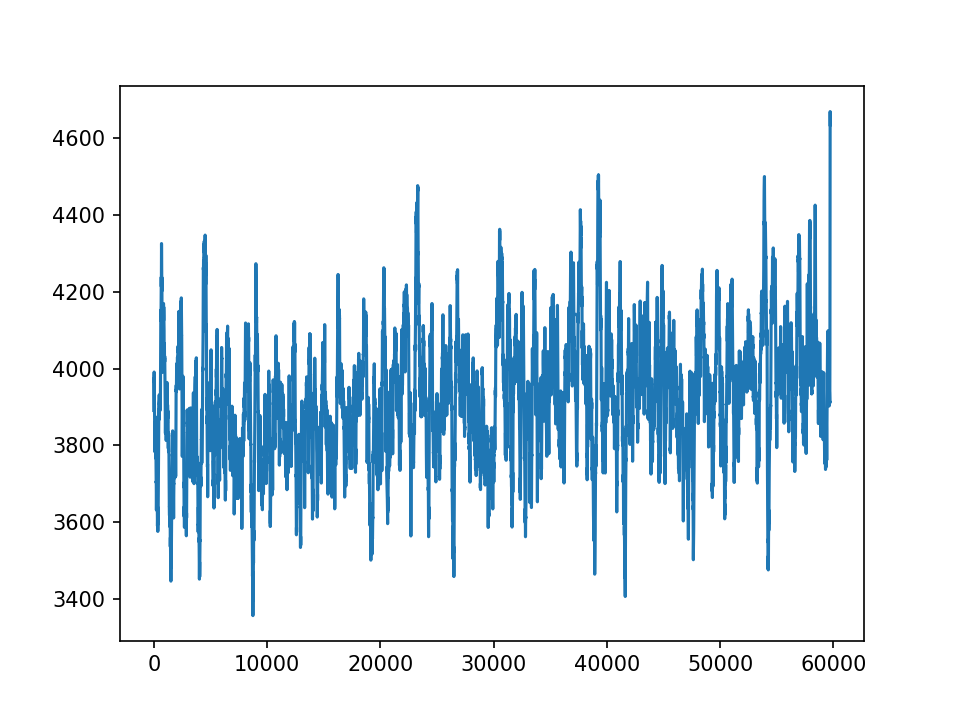

In [24]:
N = int(1.5/binsize) # für eine Secunde, das Sliding window, also letztlich number of bins

# gaussian smmothing fo the firing rate and moving average
fr_gau = gaussian_smoothing(firing_rate)
ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='valid')
plt.plot(ma_fr_gau)

In [25]:
# we look for the mean of the MA as threshold
# we arrange this mean in an array for plotting
mean_ma_fr_gau = np.mean(ma_fr_gau)
std_ma_fr_gau = np.std(ma_fr_gau)
network_burst_threshold = mean_ma_fr_gau
shape_for_threshold = np.shape(ma_fr_gau)
network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)
    

In [26]:
#network_burst_threshold = 1*std_ma_fr_gau

In [27]:
# now we identify the burts from the network and will extract an array with 
# tuples containing the burst start and end times
bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []
for index in range(0, len(ma_fr_gau[:-N])):
    if ma_fr_gau[index+N] > network_burst_threshold:
        if ma_fr_gau[index+N-1] <= network_burst_threshold:
            burst_start.append(index+N)
        if index == 0:
            burst_start.append(0)
            #burst_seconds_start.append((index+N)*0.005)
    else:
        if (ma_fr_gau[index+N-1] > network_burst_threshold) and (len(burst_start)>0):
            if index+N > len(ma_fr_gau):
                ending = len(ma_fr_gau)
            else: 
                ending = index + N

            burst_end.append(ending)
            #burst_seconds_end.append((ending)*0.005)
bursts = list(zip(burst_start, burst_end))
    

In [28]:
# get the bursts into seconds
for i in burst_start:
    burst_seconds_start.append(firing_rate_histogram[1][i])
for i in burst_end:
    burst_seconds_end.append(firing_rate_histogram[1][i])

bursts_seconds = list(zip(burst_seconds_start, burst_seconds_end))
# bursts sind jetzt im 5ms bin 
    

<IPython.core.display.Javascript object>


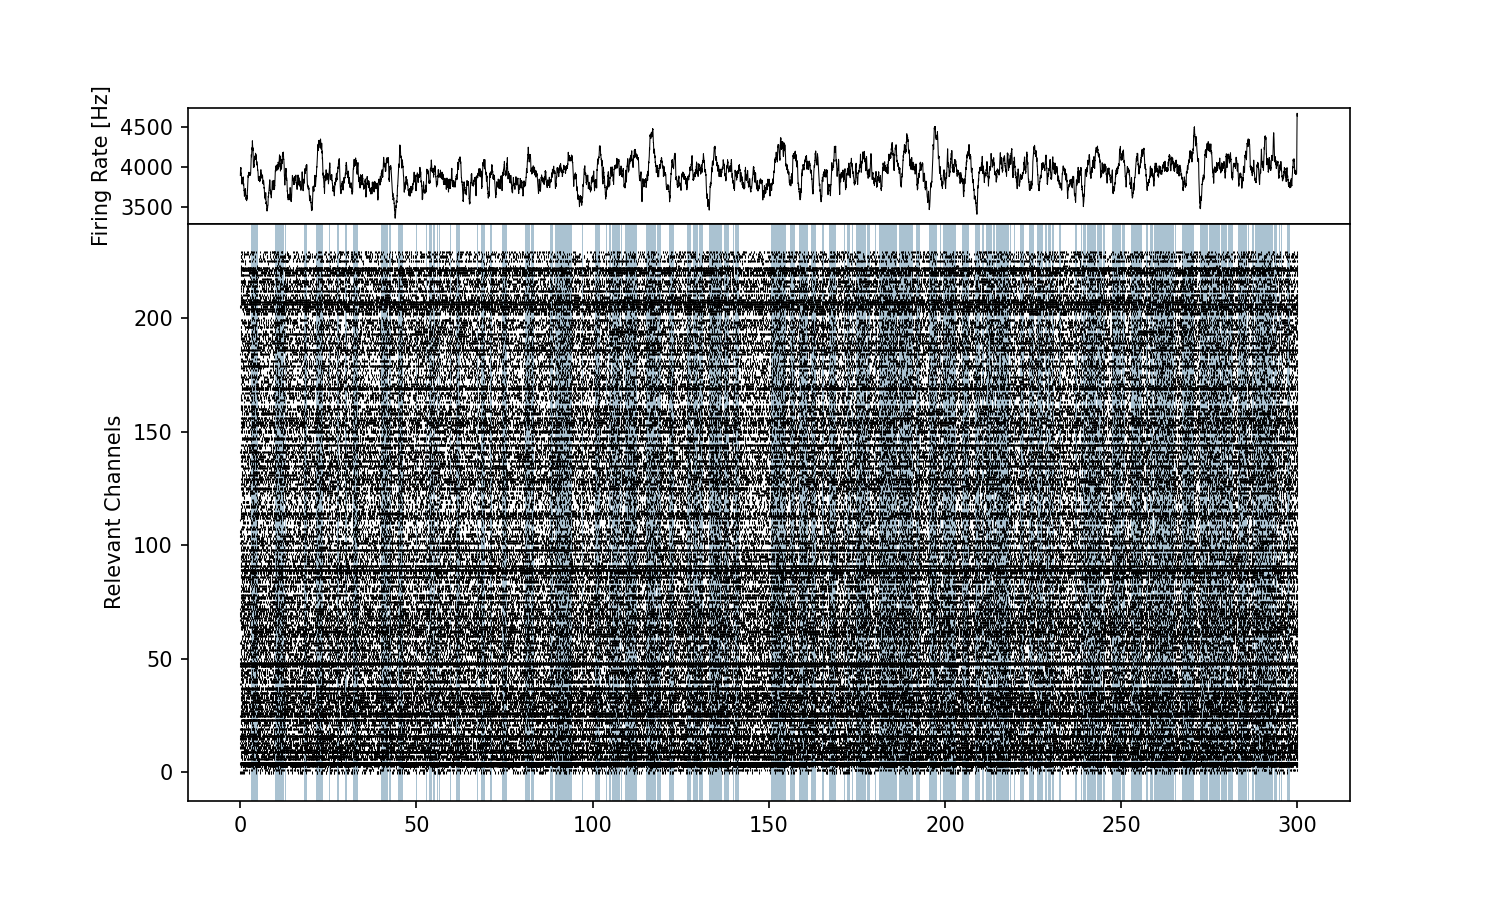

<ipython-input-29-4f779ef7dca5>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


In [29]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black', linewidth = 0.5)
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot.png', dpi=300)



<IPython.core.display.Javascript object>


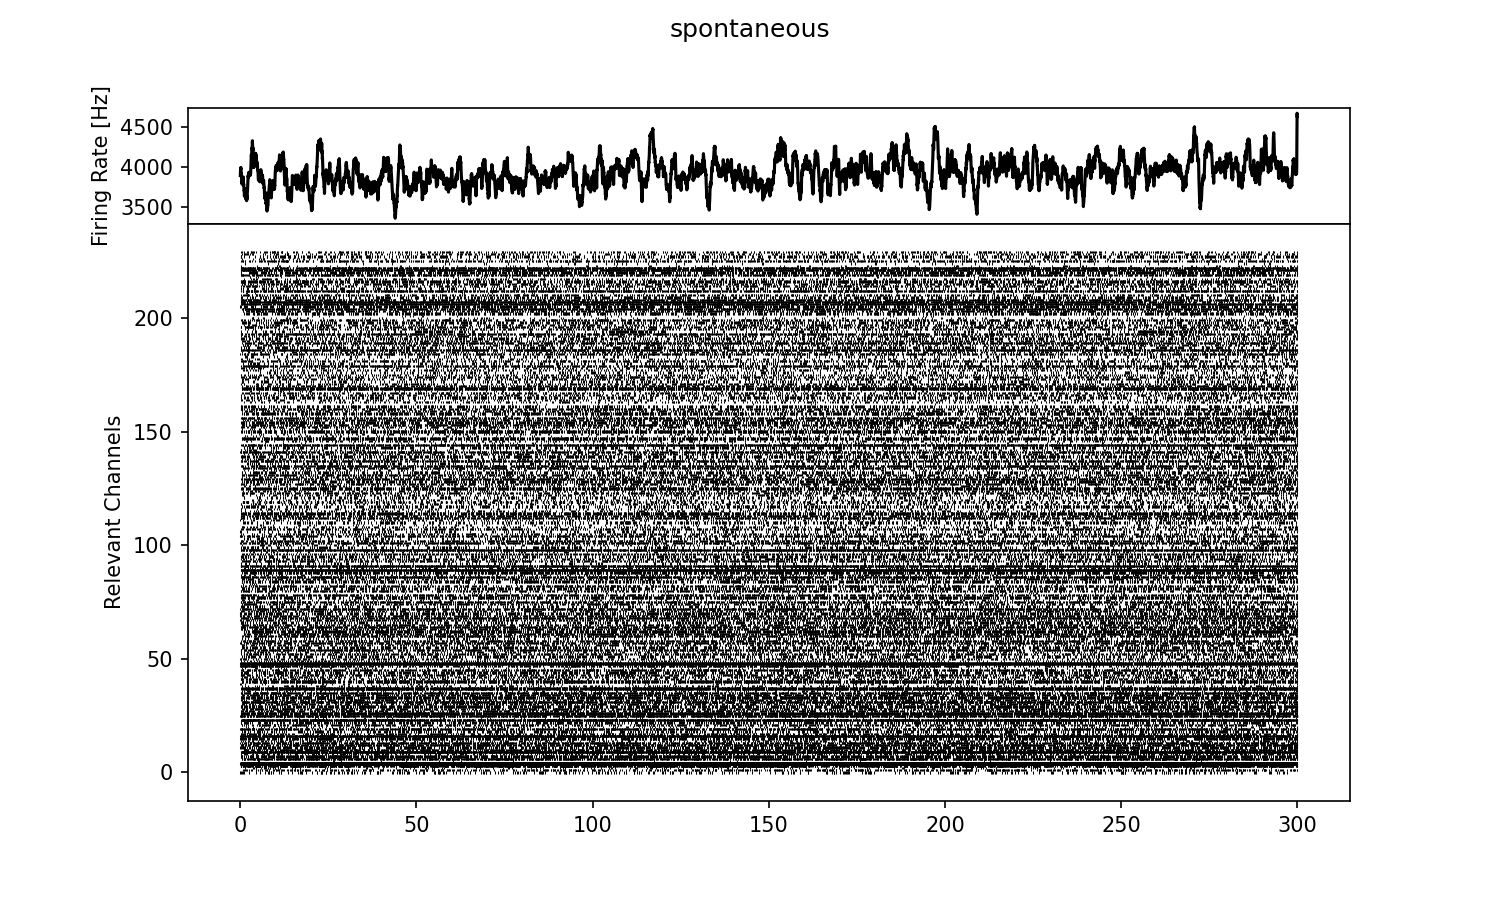

<ipython-input-30-c4b666c2c0f1>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


Text(0.5, 0.98, 'spontaneous')

In [30]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')
fig.suptitle(filename)

#for ax in axs:
#    for i in bursts_seconds:
#        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.png', dpi=300)

In [31]:
# identify the longest burst and longest interburst-interval


In [32]:
#longest bursts:

longest_burst = 0
longest_burst_i = 0
for i in bursts_seconds:
    burstinterval = i[1]-i[0]
    if burstinterval > longest_burst:
        longest_burst = burstinterval
        longest_burst_i = i

In [33]:
# longest_interburst interval:

longest_ibi = 0
longest_ibi_times = (0, 0)

for i in range(1, len(bursts_seconds)-1):
    ibi = bursts_seconds[i+1][0] - bursts_seconds[i][1]
    if ibi > longest_ibi:
        longest_ibi = ibi
        longest_ibi_times = ((bursts_seconds[i][1]), (bursts_seconds[i+1][0])) 

In [34]:
longest_ibi_times

(33.333369069848835, 39.8330666082232)

<IPython.core.display.Javascript object>


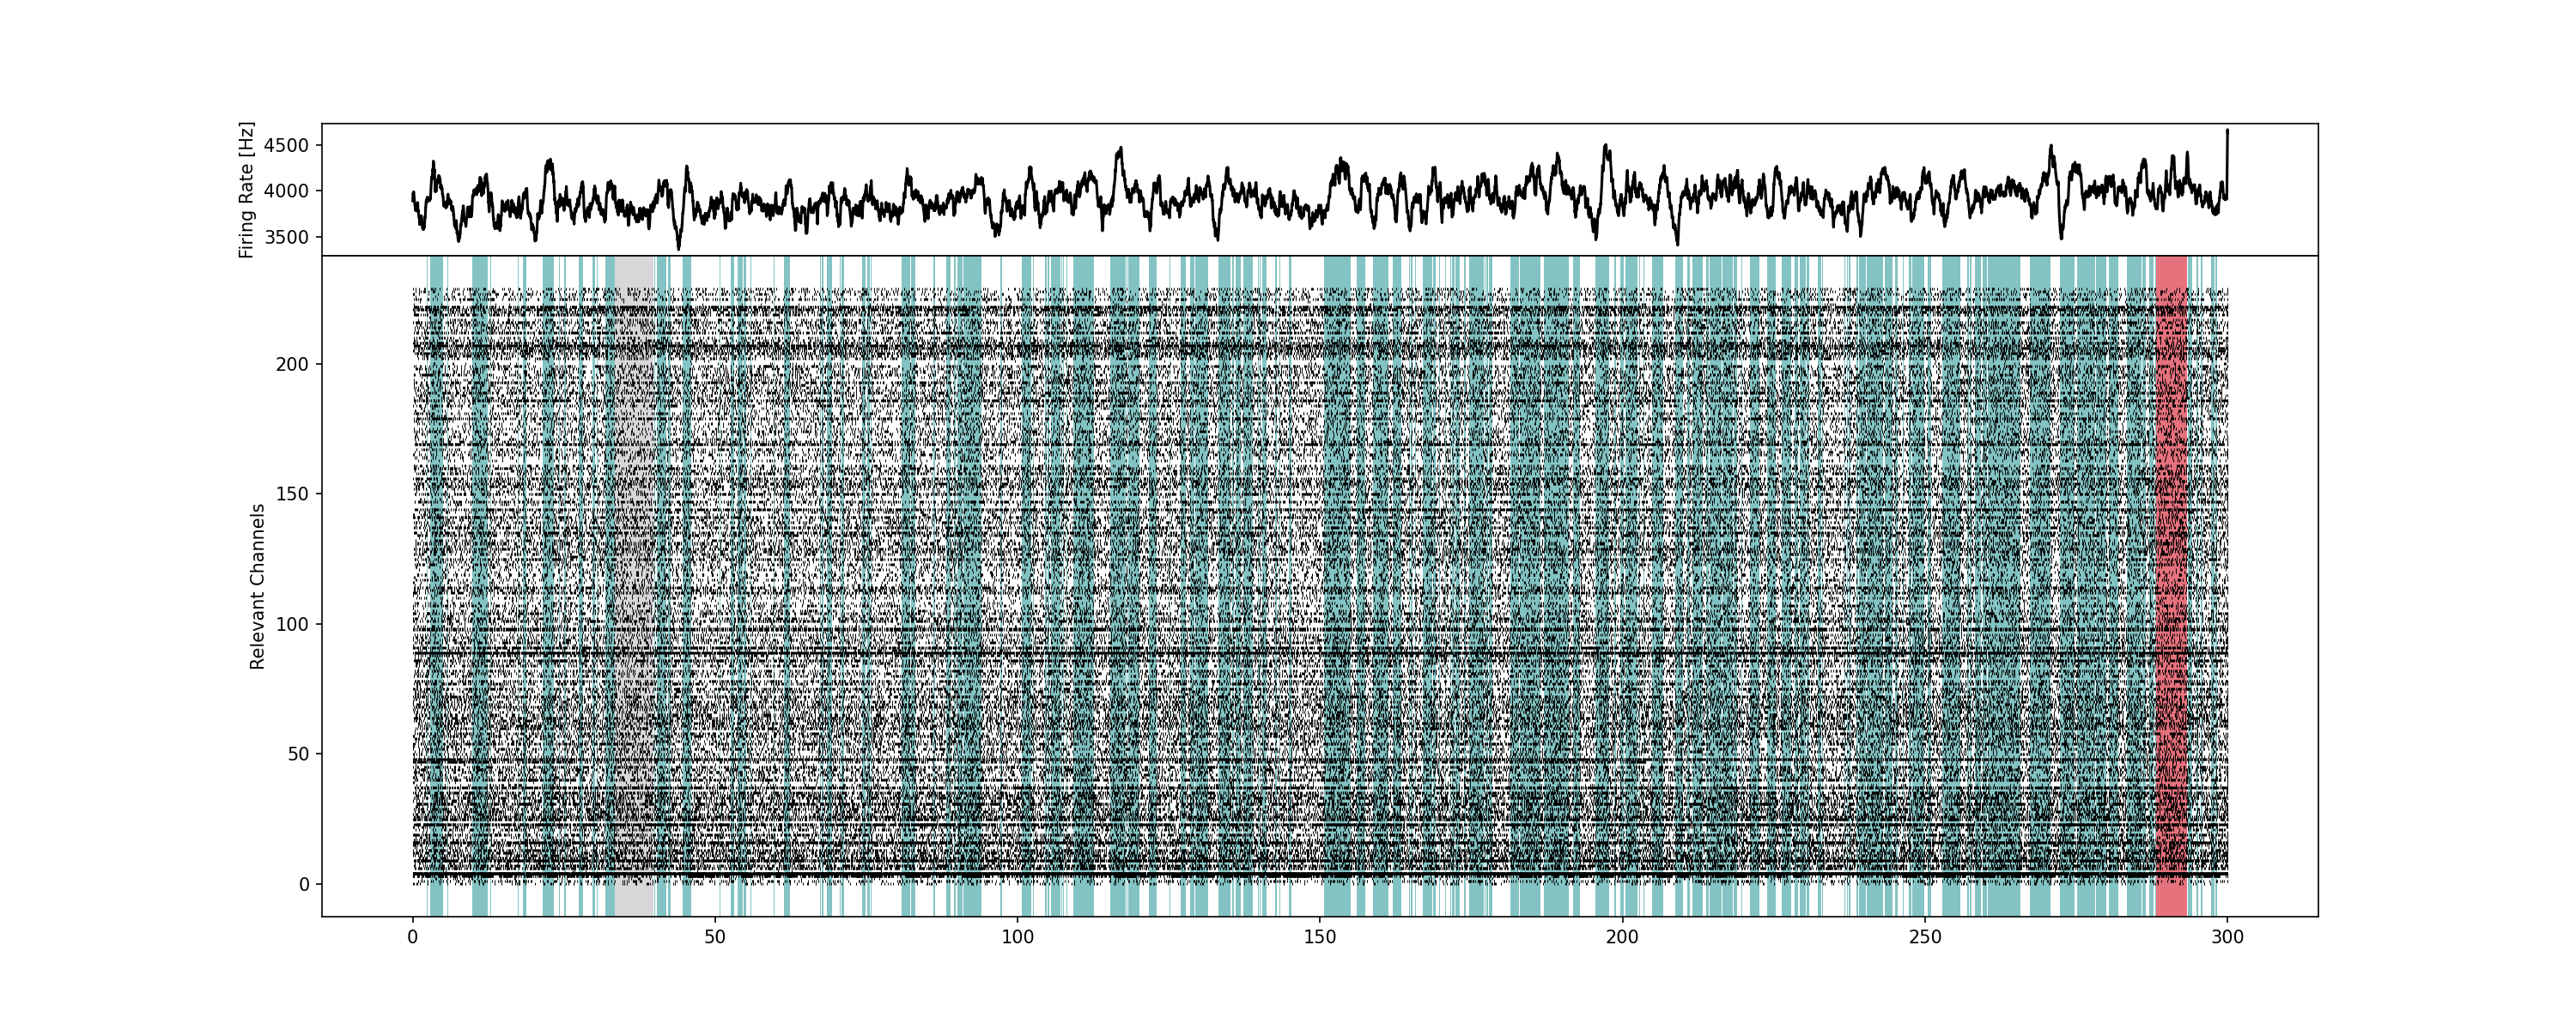

In [35]:
fig = plt.figure(figsize = (20,8))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        axs[1].axvspan(longest_burst_i[0], longest_burst_i[1], facecolor = '#F2727D', alpha = 0.2, label = 'longest network burst')
        axs[1].axvspan(longest_ibi_times[0], longest_ibi_times[1], facecolor = '#D7D7D9', alpha = 0.1, ls =':')
        
#fig.savefig(filename+'raster_and_FR_plot.png', dpi=300)
        


In [36]:
# next, we want to isolate these two areas for a spade analysis

In [37]:
def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

In [38]:
burst_seconds_start

[2.359810415826403,
 2.6397973867102213,
 2.8397880801986632,
 2.9247841249312514,
 5.729653601106649,
 9.824463050282496,
 12.774325779237014,
 17.434108937517706,
 18.1540754340761,
 18.364065662238964,
 21.523918619356344,
 23.388831836136063,
 24.203793912101464,
 24.348787164880587,
 25.063753894101765,
 27.393645473242113,
 29.67853914634756,
 29.753535656405727,
 30.223513786103567,
 30.463502618289695,
 31.85843770537158,
 33.033383029616175,
 39.8330666082232,
 39.978059861002315,
 40.303044737921034,
 42.16295818736354,
 44.6328432519458,
 49.08763594940085,
 49.99259383743605,
 50.6975610319828,
 50.937549864168936,
 52.62747122414627,
 53.03245237846036,
 53.64742376093732,
 54.722373738437696,
 55.877319993333444,
 56.48229184113598,
 56.952269970833825,
 57.10726275828736,
 59.657144100265,
 61.34206569290512,
 67.29678859152348,
 67.59177486441892,
 67.6667713744771,
 68.01175532074465,
 68.45673461375644,
 69.41169017516376,
 70.64663270745488,
 70.66663177680373,
 70.7

In [39]:
burst_seconds_end

[2.4248073912101464,
 2.6597964560590657,
 2.8497876148730854,
 5.0246864065598915,
 5.854647784536925,
 12.434341600306663,
 12.989315774737088,
 17.499105912901452,
 18.34906636022733,
 18.81404472258796,
 23.353833464775587,
 23.393831603473277,
 24.28878995683405,
 24.378785768903853,
 25.37373946900885,
 28.10861220246329,
 29.698538215696406,
 30.14351750870819,
 30.228513553440777,
 30.558498197696707,
 32.97838558890685,
 33.333369069848835,
 39.84306614289762,
 40.1030540444326,
 41.942968424526256,
 42.637936084398596,
 46.04777740837653,
 49.11763455342411,
 50.01259290678489,
 50.8325547500875,
 50.9675484681922,
 53.00245377443709,
 53.11244865585574,
 54.53738234696089,
 55.14735396210063,
 55.98731487475209,
 56.55728835119415,
 56.99226810953151,
 57.122262060299,
 59.777138516358065,
 62.39701660105665,
 67.49677928501193,
 67.60677416643057,
 67.86176230062833,
 68.10175113281446,
 69.34669319978,
 69.43668901184981,
 70.66163200946652,
 70.69163061348978,
 70.7966257

In [40]:
st_longest_burst = subdivide_spiketrain(spikedic_SC, longest_burst_i[0], longest_burst_i[1])

In [41]:
st_longest_ibi = subdivide_spiketrain(spikedic_SC, longest_ibi_times[0], longest_ibi_times[1])

In [42]:
# in the next step, we want to find the firing rates for every channel in hertz for these subdivisions

longest_burst_firingrate_dic = {}

for key in st_longest_burst:
    fr_channel = len(st_longest_burst[key])/longest_burst # i.e, number of spikes divided by duration -> results in number per second
    longest_burst_firingrate_dic[key] = fr_channel

In [43]:
# same is done for the longest interburst interval

longest_ibi_firingrate_dic = {}

for key in st_longest_ibi:
    fr_channel = len(st_longest_ibi[key])/longest_ibi # i.e, number of spikes divided by duration -> results in number per second
    longest_ibi_firingrate_dic[key] = fr_channel

In [44]:
# and lastly for the whole recording

whole_recording_firingrate_dic = {}

for key in spikedic_SC:
    fr_channel = len(spikedic_SC[key])/timelengthrecording_s # i.e, number of spikes divided by duration -> results in number per second
    whole_recording_firingrate_dic[key] = fr_channel

In [45]:
# next we plot this on a mea array:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

df1 = pd.DataFrame(data=mea_array,columns=columnlist)
df1.index+=1

df2 = pd.DataFrame(data=mea_array,columns=columnlist)
df2.index+=1


In [46]:
# function to fill the dataframe with the 

def get_dict_values(df, dic):
    
    for i in df.columns:
        for j in range(0, 16):
            keystring = i+str(df.index[j])
            #print(keystring)
            if keystring in dic.keys():
                df.loc[df.index[j],i]=dic[keystring]
            
                
    
    return df

In [47]:
use_df_copy = df.copy()
use_df_copy1 = df1.copy()
use_df_copy2 = df2.copy()

In [48]:
#the dataframe for burst


df_fr_burst = get_dict_values(use_df_copy, longest_burst_firingrate_dic)

In [49]:
df_fr_burst

A         B         C         D         E          F          G  \
1        NaN  1.397271       NaN       NaN  4.990252   3.393371   1.197661   
2        NaN  3.792592  1.596881  2.195711  0.399220   2.594931   2.195711   
3   3.592982  2.794541  7.385573  0.598830  2.594931        NaN   5.788693   
4   0.998050  2.195711  1.996101  5.389472       NaN        NaN   0.000000   
5   1.197661  0.798440  0.399220  0.399220  2.994151   3.193761   0.399220   
6   2.395321  8.184014  1.996101  5.389472  3.193761   2.794541   1.996101   
7   5.389472  3.193761  3.393371  5.988303  1.996101   3.992202   3.792592   
8   2.594931  1.996101  5.389472  4.191812  3.992202   2.794541   2.195711   
9   0.399220  3.792592  1.796491  3.393371  2.195711   3.792592   2.994151   
10  2.395321  1.596881  1.197661  7.385573  8.982454   8.383624        NaN   
11  4.191812  5.389472  6.187913  4.191812  5.189862   2.195711   7.185963   
12  3.193761  5.389472  2.994151  2.794541  0.399220  11.178165   2.994151   
13  8.184014  0.000000  3.992202  4.191812  5.988303   5.589082  13.174266   
14       NaN  1.596881  2.794541  0.798440  4.790642   2.594931   3.992202   
15       NaN  3.592982  7.385573  1.596881  4.391422   1.796491   3.193761   
16       NaN  3.792592  5.589082  1.197661       NaN   6.187913   3.992202   

           H         I         K         L         M         N          O  \
1   3.393371  4.391422  8.184014  5.589082  1.397271  4.191812   0.399220   
2   2.395321       NaN  1.197661  0.399220  4.591032  2.395321   0.798440   
3        NaN  0.798440  1.796491  5.589082  4.391422  6.187913   2.594931   
4   0.798440  1.996101  3.193761  6.986353  9.182064  3.393371  18.364128   
5   7.385573  2.594931  2.794541  1.596881  3.592982  3.592982  14.771146   
6   2.195711  4.191812  4.990252  6.786743  1.996101  5.389472   0.000000   
7   1.197661  2.794541  1.197661  1.397271  2.994151  8.184014   4.990252   
8   1.197661  2.395321  1.796491  6.387523  1.996101  5.189862   4.990252   
9   7.185963  4.391422       NaN  3.792592  6.786743  0.199610   7.585183   
10  1.596881  4.191812  3.592982  0.598830  5.788693  0.798440  12.775046   
11  6.187913  1.197661  3.792592  6.387523  2.395321  4.191812   2.195711   
12  6.986353  0.199610  3.193761  5.389472  4.790642  0.798440   0.598830   
13  5.589082  2.195711  1.596881  0.598830  1.996101  4.191812   1.796491   
14  5.189862  0.598830  0.998050       NaN       NaN  4.391422   3.592982   
15       NaN       NaN  2.794541  5.589082  2.794541  0.998050   0.598830   
16       NaN  0.000000  0.798440  1.596881  1.796491  3.792592        NaN   

           P          R  
1   3.193761        NaN  
2   2.395321        NaN  
3   1.996101  24.552041  
4   1.796491   0.798440  
5   0.798440   3.193761  
6   2.395321   4.391422  
7   1.397271   2.994151  
8   4.191812   5.788693  
9   8.982454   2.195711  
10  2.794541   3.393371  
11  6.187913   2.594931  
12  2.594931        NaN  
13       NaN   1.996101  
14  4.591032   3.193761  
15  0.798440   2.395321  
16  1.397271        NaN

In [50]:
# data frame for interburst interval
df_fr_ibi = get_dict_values(use_df_copy1, longest_ibi_firingrate_dic)

In [51]:
df_fr_burst

A         B         C         D         E          F          G  \
1        NaN  1.397271       NaN       NaN  4.990252   3.393371   1.197661   
2        NaN  3.792592  1.596881  2.195711  0.399220   2.594931   2.195711   
3   3.592982  2.794541  7.385573  0.598830  2.594931        NaN   5.788693   
4   0.998050  2.195711  1.996101  5.389472       NaN        NaN   0.000000   
5   1.197661  0.798440  0.399220  0.399220  2.994151   3.193761   0.399220   
6   2.395321  8.184014  1.996101  5.389472  3.193761   2.794541   1.996101   
7   5.389472  3.193761  3.393371  5.988303  1.996101   3.992202   3.792592   
8   2.594931  1.996101  5.389472  4.191812  3.992202   2.794541   2.195711   
9   0.399220  3.792592  1.796491  3.393371  2.195711   3.792592   2.994151   
10  2.395321  1.596881  1.197661  7.385573  8.982454   8.383624        NaN   
11  4.191812  5.389472  6.187913  4.191812  5.189862   2.195711   7.185963   
12  3.193761  5.389472  2.994151  2.794541  0.399220  11.178165   2.994151   
13  8.184014  0.000000  3.992202  4.191812  5.988303   5.589082  13.174266   
14       NaN  1.596881  2.794541  0.798440  4.790642   2.594931   3.992202   
15       NaN  3.592982  7.385573  1.596881  4.391422   1.796491   3.193761   
16       NaN  3.792592  5.589082  1.197661       NaN   6.187913   3.992202   

           H         I         K         L         M         N          O  \
1   3.393371  4.391422  8.184014  5.589082  1.397271  4.191812   0.399220   
2   2.395321       NaN  1.197661  0.399220  4.591032  2.395321   0.798440   
3        NaN  0.798440  1.796491  5.589082  4.391422  6.187913   2.594931   
4   0.798440  1.996101  3.193761  6.986353  9.182064  3.393371  18.364128   
5   7.385573  2.594931  2.794541  1.596881  3.592982  3.592982  14.771146   
6   2.195711  4.191812  4.990252  6.786743  1.996101  5.389472   0.000000   
7   1.197661  2.794541  1.197661  1.397271  2.994151  8.184014   4.990252   
8   1.197661  2.395321  1.796491  6.387523  1.996101  5.189862   4.990252   
9   7.185963  4.391422       NaN  3.792592  6.786743  0.199610   7.585183   
10  1.596881  4.191812  3.592982  0.598830  5.788693  0.798440  12.775046   
11  6.187913  1.197661  3.792592  6.387523  2.395321  4.191812   2.195711   
12  6.986353  0.199610  3.193761  5.389472  4.790642  0.798440   0.598830   
13  5.589082  2.195711  1.596881  0.598830  1.996101  4.191812   1.796491   
14  5.189862  0.598830  0.998050       NaN       NaN  4.391422   3.592982   
15       NaN       NaN  2.794541  5.589082  2.794541  0.998050   0.598830   
16       NaN  0.000000  0.798440  1.596881  1.796491  3.792592        NaN   

           P          R  
1   3.193761        NaN  
2   2.395321        NaN  
3   1.996101  24.552041  
4   1.796491   0.798440  
5   0.798440   3.193761  
6   2.395321   4.391422  
7   1.397271   2.994151  
8   4.191812   5.788693  
9   8.982454   2.195711  
10  2.794541   3.393371  
11  6.187913   2.594931  
12  2.594931        NaN  
13       NaN   1.996101  
14  4.591032   3.193761  
15  0.798440   2.395321  
16  1.397271        NaN

<IPython.core.display.Javascript object>


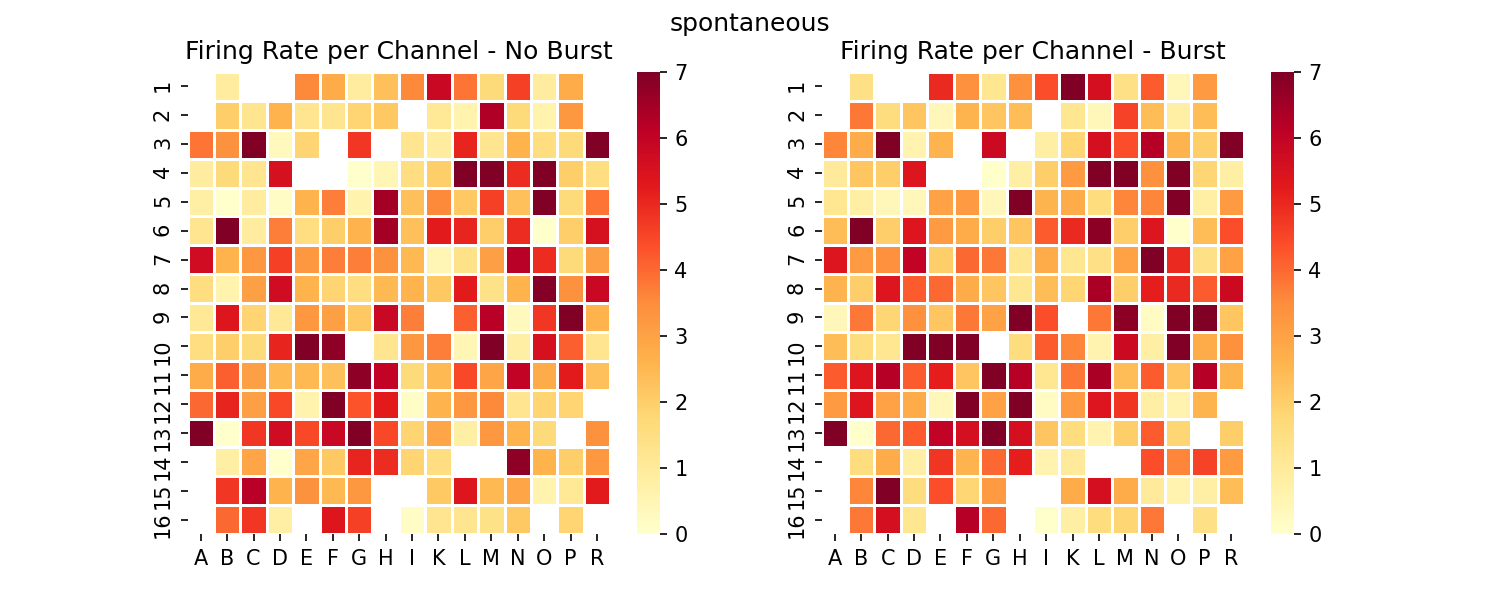

Text(0.5, 1.0, 'Firing Rate per Channel - Burst')

In [52]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

f.suptitle(filename)
sns.heatmap(df_fr_ibi, annot=False, linewidths=.5, ax=ax1, cmap="YlOrRd", vmax=7)
ax1.set_title('Firing Rate per Channel - No Burst')


sns.heatmap(df_fr_burst, annot=False, linewidths=.5, ax=ax2, cmap="YlOrRd", vmax=7)
ax2.set_title('Firing Rate per Channel - Burst')

#f.savefig(filename+'_MEA_Heatmap.png', dpi = 300)



In [53]:
df_fr_whole = get_dict_values(use_df_copy2, whole_recording_firingrate_dic)

In [54]:
df_fr_whole

A         B         C         D         E         F          G  \
1        NaN  1.043333       NaN       NaN  4.506667  2.350000   1.480000   
2        NaN  2.983333  1.133333  2.426667  1.523333  1.480000   1.816667   
3   3.740000  3.050000  7.970000  0.216667  3.010000       NaN   5.090000   
4   1.400000  1.443333  1.250000  5.683333       NaN       NaN   0.073333   
5   1.130000  0.193333  0.880000  0.330000  2.263333  3.520000   0.303333   
6   1.103333  8.513333  1.793333  3.670000  2.620000  2.533333   3.820000   
7   5.523333  2.760000  3.106667  4.123333  2.406667  3.386667   3.383333   
8   1.560000  1.143333  3.826667  4.546667  2.793333  2.453333   1.610000   
9   0.853333  4.900000  1.753333  1.783333  3.426667  2.940000   3.353333   
10  2.083333  1.663333  1.733333  5.353333  8.343333  6.886667        NaN   
11  3.986667  4.310000  3.246667  3.206667  3.880000  2.476667   6.516667   
12  3.190000  4.670000  3.053333  4.050000  0.533333  9.306667   4.093333   
13  7.763333  0.130000  5.096667  5.186667  5.386667  5.823333  11.283333   
14       NaN  1.006667  3.000000  0.410000  4.360000  2.710000   4.593333   
15       NaN  3.883333  5.376667  1.473333  3.753333  2.946667   2.463333   
16       NaN  4.586667  3.356667  1.370000       NaN  4.670000   4.190000   

           H         I         K         L          M         N          O  \
1   3.093333  3.613333  6.756667  4.720000   1.686667  4.780000   0.636667   
2   2.996667       NaN  0.873333  1.140000   5.213333  2.666667   0.983333   
3        NaN  1.563333  1.860000  4.633333   2.113333  3.836667   1.483333   
4   0.556667  1.433333  2.376667  7.490000  11.030000  6.186667  15.343333   
5   6.116667  2.636667  3.320000  2.906667   4.286667  2.670000  11.303333   
6   6.476667  3.440000  4.326667  6.453333   2.506667  4.716667   0.080000   
7   2.403333  2.543333  0.636667  1.386667   2.920000  6.360000   5.040000   
8   1.943333  3.356667  2.113333  5.856667   2.233333  4.066667   5.726667   
9   4.723333  3.893333       NaN  4.620000   6.706667  0.386667   5.646667   
10  1.546667  3.513333  4.656667  0.536667   7.086667  1.063333  11.376667   
11  7.130000  1.766667  3.030000  5.156667   3.160000  4.826667   2.090000   
12  5.003333  0.593333  2.550000  3.716667   3.970000  1.333333   1.196667   
13  4.926667  1.910000  1.496667  0.726667   2.346667  3.673333   1.456667   
14  4.286667  1.456667  1.886667       NaN        NaN  4.870000   3.246667   
15       NaN       NaN  2.183333  5.773333   2.596667  1.956667   0.856667   
16       NaN  0.156667  0.640000  1.243333   1.473333  2.630000        NaN   

           P          R  
1   2.836667        NaN  
2   1.896667        NaN  
3   2.440000  24.213333  
4   2.440000   1.213333  
5   1.386667   2.293333  
6   2.266667   4.980000  
7   2.393333   3.343333  
8   4.216667   5.250000  
9   8.136667   2.693333  
10  4.023333   2.676667  
11  5.813333   2.213333  
12  2.356667        NaN  
13       NaN   2.773333  
14  2.990000   3.713333  
15  1.040000   4.540000  
16  2.640000        NaN

In [55]:
df_fr_whole_normalized =(df_fr_whole-df_fr_whole.mean().max())/df_fr_whole.mean().std()

In [56]:
df_fr_whole_normalized

A         B         C         D         E         F         G  \
1        NaN -5.660218       NaN       NaN -0.695631 -3.787150 -5.034269   
2        NaN -2.879285 -5.531205 -3.677250 -4.972152 -5.034269 -4.551667   
3  -1.794626 -2.783720  4.268955 -6.845220 -2.841059       NaN  0.140560   
4  -5.148947 -5.086830 -5.363967  0.991086       NaN       NaN -7.050684   
5  -5.535984 -6.878668 -5.894351 -6.682760 -3.911384 -2.109989 -6.720986   
6  -5.574210  5.047807 -4.585115 -1.894968 -3.400113 -3.524347 -1.679948   
7   0.761730 -3.199427 -2.702490 -1.245128 -3.705920 -2.301118 -2.305897   
8  -4.919591 -5.516871 -1.670391 -0.638293 -3.151644 -3.639024 -4.847918   
9  -5.932577 -0.131800 -4.642454 -4.599450 -2.243780 -2.941402 -2.348901   
10 -4.169408 -4.771466 -4.671123  0.518040  4.804117  2.716029       NaN   
11 -1.441036 -0.977547 -2.501804 -2.559143 -1.593940 -3.605577  2.185644   
12 -2.583034 -0.461498 -2.778942 -1.350250 -6.391288  6.185027 -1.288133   
13  3.972704 -6.969454  0.150116  0.279129  0.565823  1.191771  9.018521   
14       NaN -5.712778 -2.855394 -6.568082 -0.905874 -3.271100 -0.571397   
15       NaN -1.589161  0.551488 -5.043825 -1.775513 -2.931845 -3.624690   
16       NaN -0.580954 -2.344123 -5.191951       NaN -0.461498 -1.149564   

           H         I         K         L         M         N          O  \
1  -2.721603 -1.976198  2.529677 -0.389824 -4.738018 -0.303816  -6.243162   
2  -2.860172       NaN -5.903908 -5.521649  0.317354 -3.333217  -5.746226   
3        NaN -4.914813 -4.489550 -0.514058 -4.126404 -1.656057  -5.029491   
4  -6.357840 -5.101164 -3.748924  3.580889  8.655375  1.712599  14.838411   
5   1.612256 -3.376221 -2.396683 -2.989184 -1.010995 -3.328439   9.047190   
6   2.128306 -2.224667 -0.953656  2.094858 -3.562573 -0.394603  -7.041128   
7  -3.710698 -3.510012 -6.243162 -5.168060 -2.970071  1.961067   0.068886   
8  -4.370094 -2.344123 -4.126404  1.239554 -3.954388 -1.326358   1.053203   
9  -0.385046 -1.574827       NaN -0.533171  2.458004 -6.601530   0.938525   
10 -4.938704 -2.119545 -0.480611 -6.386510  3.002723 -5.631548   9.152311   
11  3.064840 -4.623341 -2.812390  0.236124 -2.626038 -0.236921  -4.159852   
12  0.016326 -6.305280 -3.500455 -1.828073 -1.464927 -5.244511  -5.440419   
13 -0.093574 -4.417877 -5.010378 -6.114150 -3.791928 -1.890190  -5.067717   
14 -1.010995 -5.067717 -4.451324       NaN       NaN -0.174804  -2.501804   
15       NaN       NaN -4.026061  1.120098 -3.433560 -4.350981  -5.927799   
16       NaN -6.931228 -6.238384 -5.373524 -5.043825 -3.385778        NaN   

           P          R  
1  -3.089527        NaN  
2  -4.436990        NaN  
3  -3.658137  27.553295  
4  -3.658137  -5.416528  
5  -5.168060  -3.868380  
6  -3.906605  -0.017122  
7  -3.725033  -2.363235  
8  -1.111338   0.369915  
9   4.507867  -3.294991  
10 -1.388476  -3.318883  
11  1.177437  -3.983057  
12 -3.777593        NaN  
13       NaN  -3.180314  
14 -2.869728  -1.832851  
15 -5.664996  -0.647849  
16 -3.371443        NaN

In [57]:
mean_fr_whole_recording

792.127

<IPython.core.display.Javascript object>


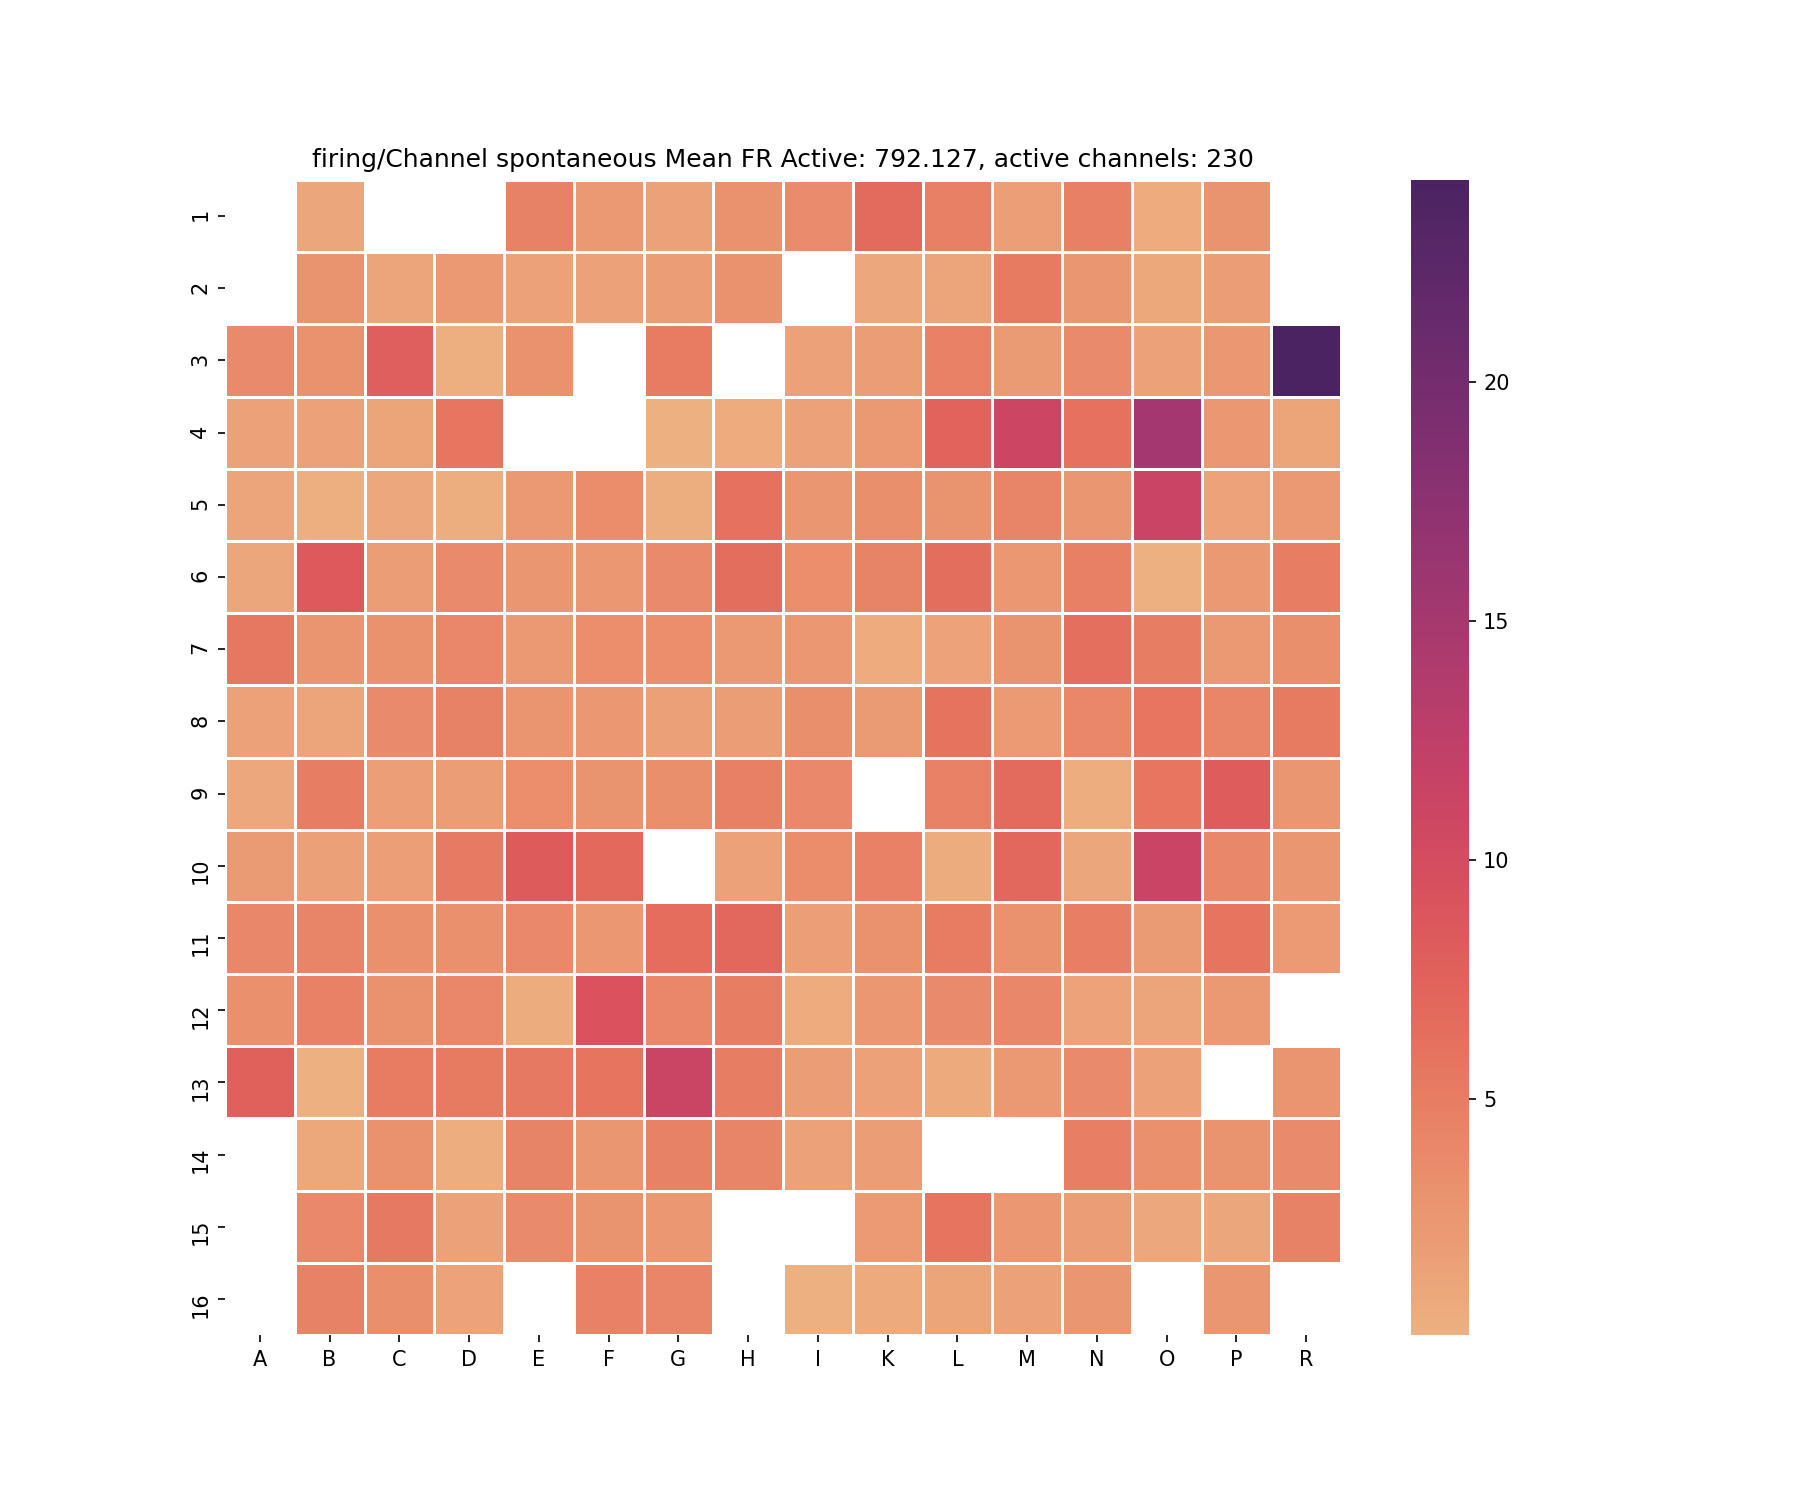

In [119]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_fr_whole, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + ' Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

f.savefig(filename+'whole_MEA_Heatmap.png', dpi = 300)

<IPython.core.display.Javascript object>


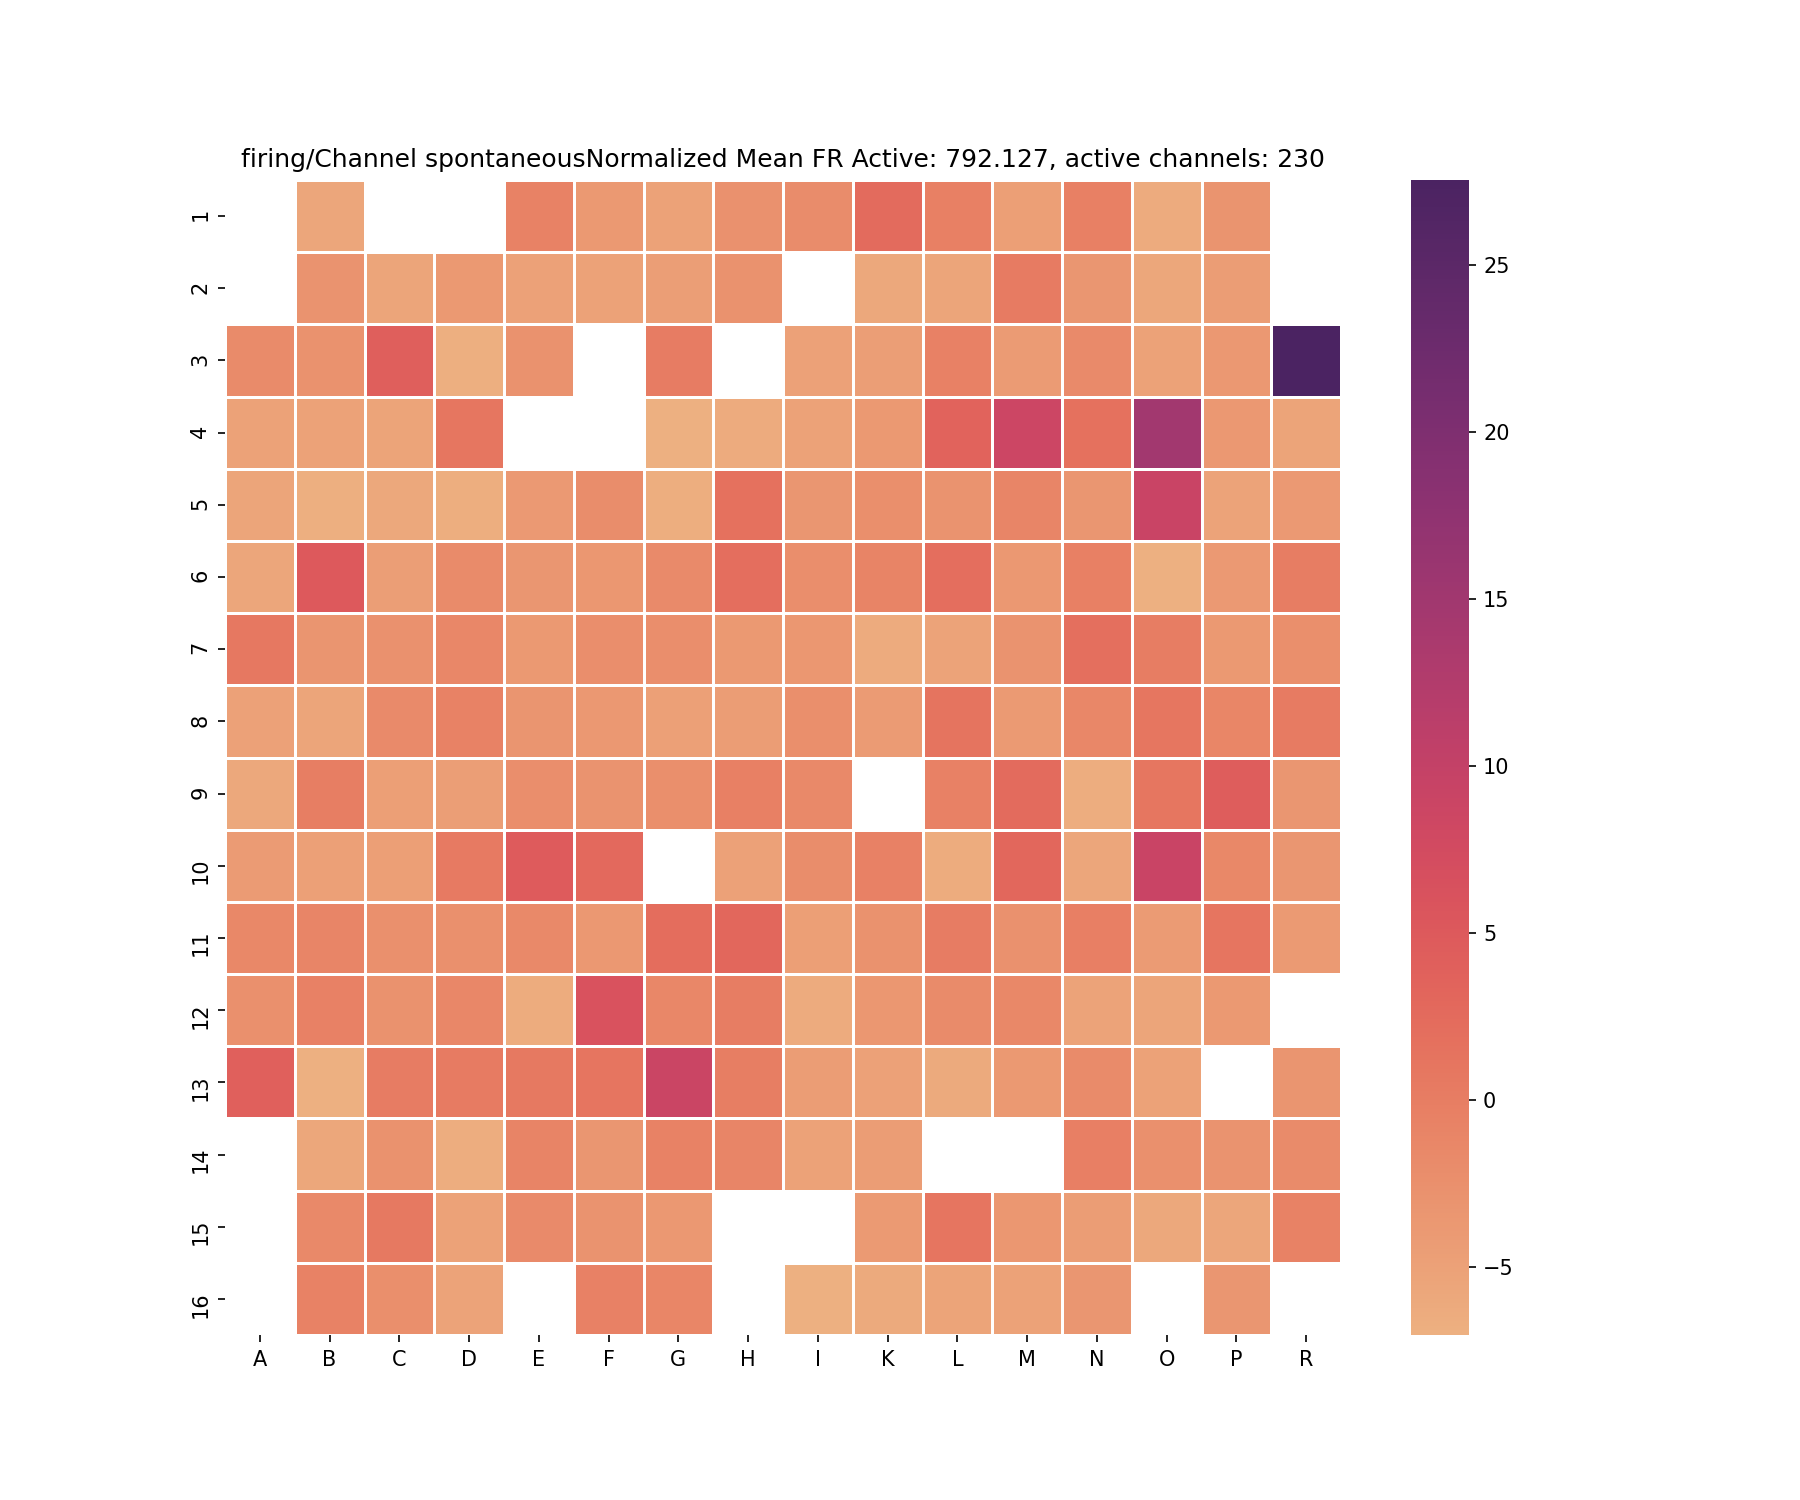

In [124]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_fr_whole_normalized, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + 'Normalized Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

f.savefig(filename+'whole_MEA_Heatmap_normalized.png', dpi = 300)

In [99]:
np.save(filename+'sub_recording_BURST.npy', st_longest_burst)
np.save(filename+'sub_recording_NON-BURST.npy', st_longest_ibi)

In [100]:
filename

'spontaneous'

In [101]:
#overviewframe_ac = pd.DataFrame(columns=['aCSF', 'aCSF + 30µM Nor', 'rewash aCSF', 'hCSF', 'hCSF + CNQX'], index=['DIV8', 'DIV11'])

In [102]:
#overviewframe_fr = pd.DataFrame(columns=['aCSF', 'aCSF + 30µM Nor', 'rewash aCSF', 'hCSF', 'hCSF + CNQX'], index=['DIV8', 'DIV11'])

In [103]:
#overviewframe_fr.iloc[0, 4]=mean_fr_whole_recording

In [104]:
#overviewframe_ac.iloc[0, 4]=active_channels

In [1406]:
#overviewframe_fr

aCSF aCSF + 30µM Nor rewash aCSF    hCSF hCSF + CNQX
DIV8   0.497           9.038       5.246  14.517       2.339
DIV11  2.781          25.947      12.122   4.741         NaN

In [1407]:
overviewframe_ac

aCSF aCSF + 30µM Nor rewash aCSF hCSF hCSF + CNQX
DIV8     7              29          20   31           9
DIV11   21             140          49   16         NaN

In [67]:
longest_burst_i

(61.8012997641196, 64.46957779069767)

# Subdivision of a Burst of Interest

In the next part we take a Network Burst and plot it on a small scale to see how the spikes develop. 

Further, we will divide it in 200ms parts to see how the spikes will develop temporarily over the MEA Grid.

<IPython.core.display.Javascript object>


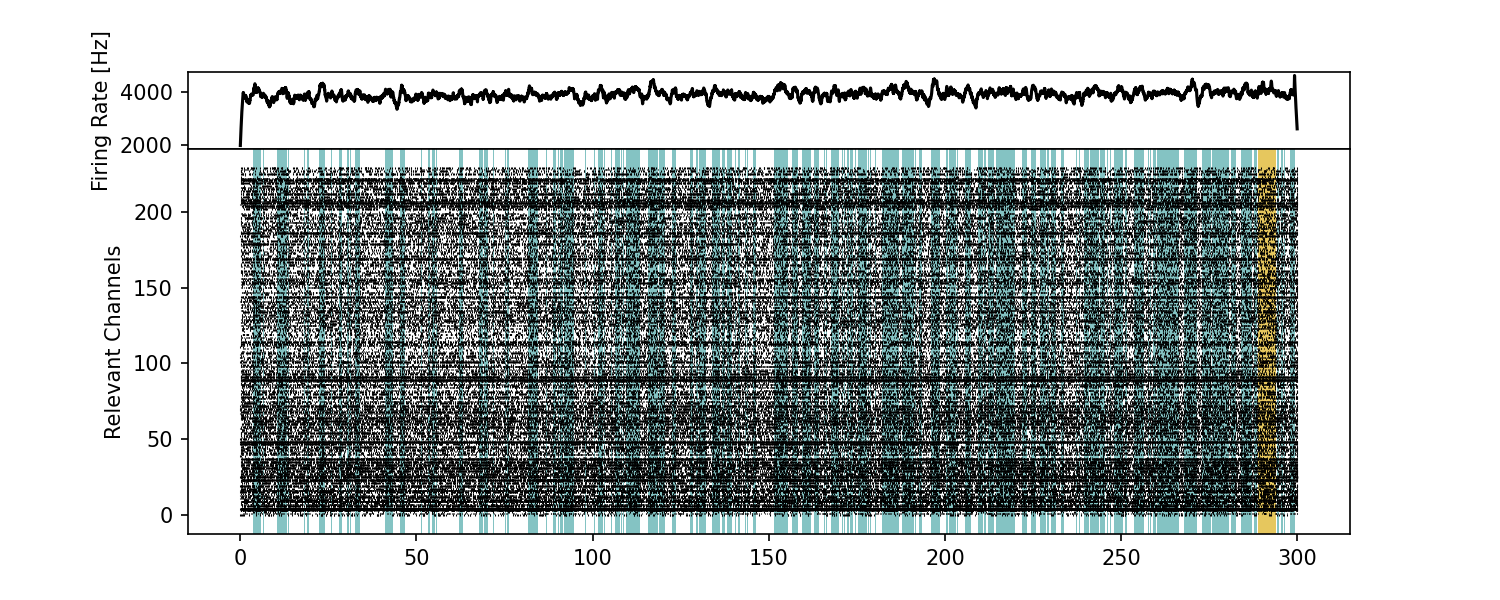

In [106]:
# we plot the beginning figure -> burst of interest is in yellow

# we choose the burst we want to plot and get start and end time in seconds
burst_of_interest = -9
b_of_interest_start = burst_seconds_start[burst_of_interest]
b_of_interest_end = burst_seconds_end[burst_of_interest]



fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        
        axs[1].axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )
        
fig.savefig(filename+'raster_and_FR_plot_09082021.png', dpi=300, bbox_inches = 'tight')

In [107]:
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

<IPython.core.display.Javascript object>


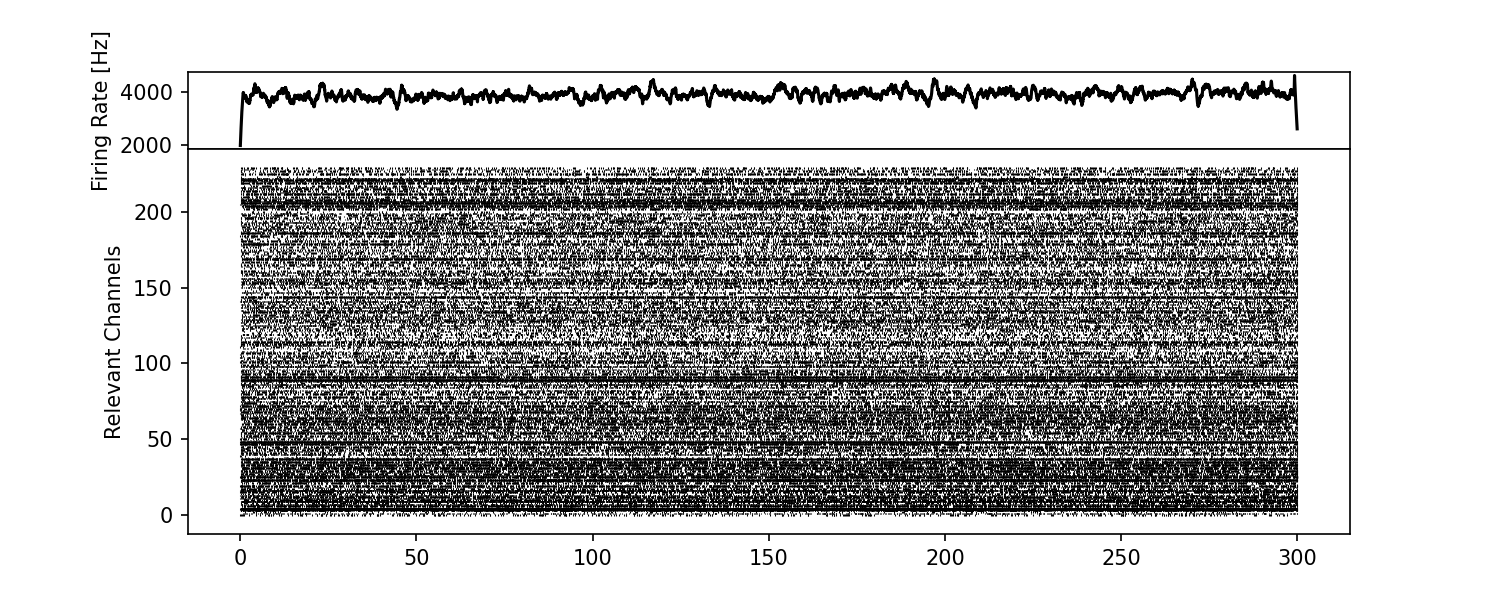

Text(0, 0.5, 'Relevant Channels')

In [108]:
# we can plot this subpart of the array

fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')


<IPython.core.display.Javascript object>


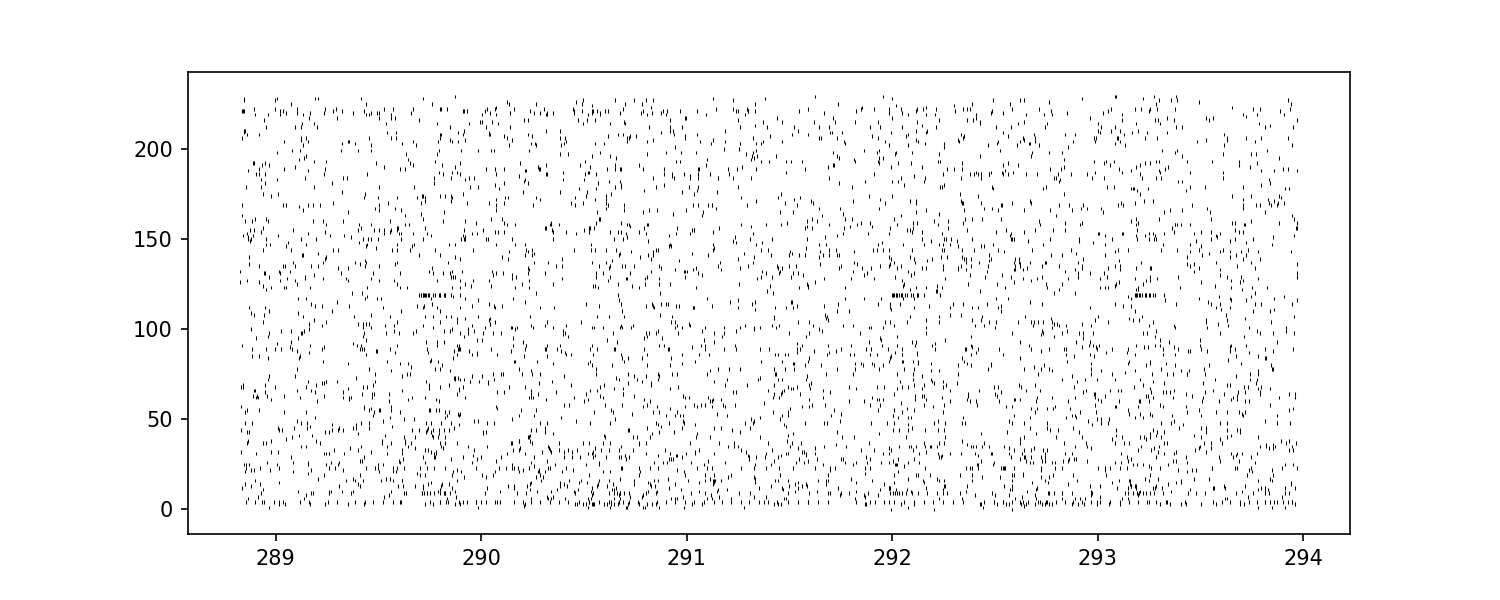

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)

In [110]:
# we use the subdivide function to get the st of the burst of interest

st_burst_of_interest = subdivide_spiketrain(spikedic_SC, b_of_interest_start, b_of_interest_end)

In [111]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# define how much time of the st you want to observe
heatmap_window = 0.2 # in seconds

#observed_time = b_of_interest_end-b_of_interest_start

#heatmap_window = observed_time/10 # in seconds


# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))
    
time_windows = time_windows[:10]


In [112]:
b_of_interest_start

288.8264797686706

In [113]:
time_windows

[(288.8265, 289.0265),
 (289.0265, 289.2265),
 (289.2265, 289.4265),
 (289.4265, 289.6265),
 (289.62649999999996, 289.8265),
 (289.82649999999995, 290.0265),
 (290.02649999999994, 290.2265),
 (290.22649999999993, 290.4265),
 (290.4264999999999, 290.6265),
 (290.6264999999999, 290.8265)]

<IPython.core.display.Javascript object>


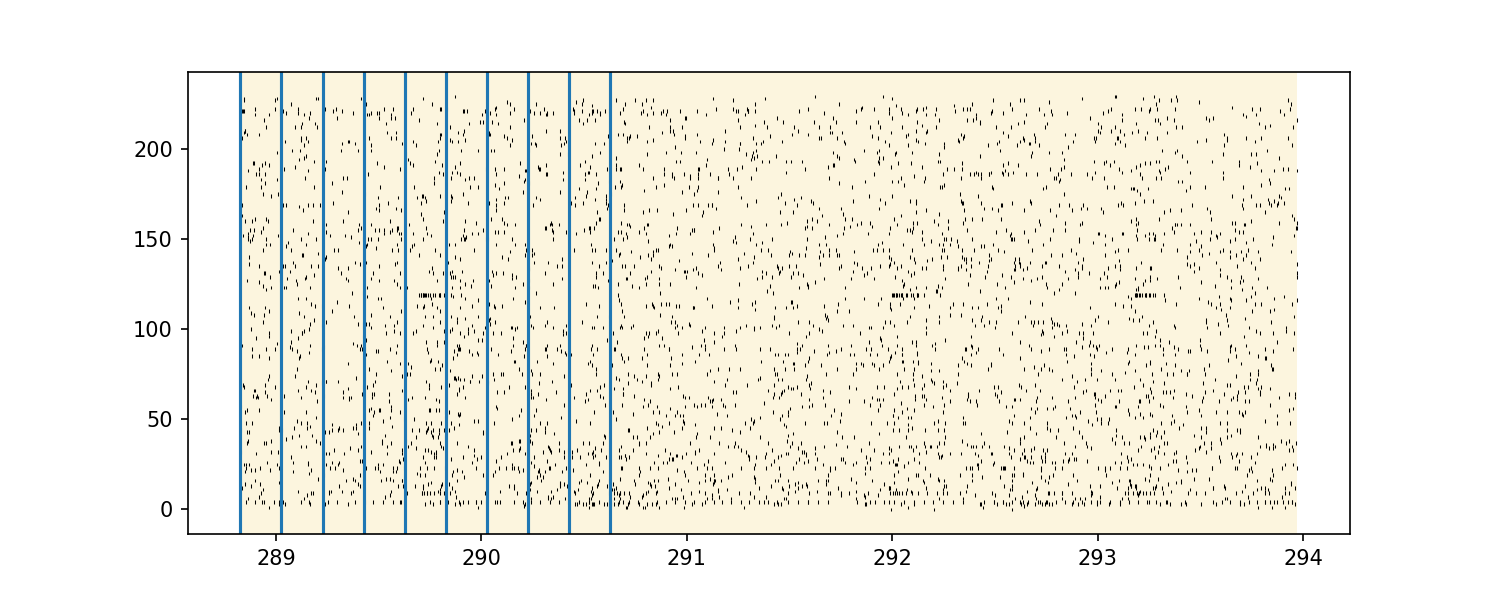

In [114]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_16082021.png', dpi=300, bbox_inches = 'tight')


In [115]:
# we can now
len(time_windows)

10

In [117]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_SC, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        
    
    

In [118]:
# how many subplots we want to create
number_of_heatmaps = len(time_windows)

number_columns = int(number_of_heatmaps / 2)




In [122]:
# for plotting with sns heatmap we need a df first 

# this is done as empty df:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1


In [123]:
df

A   B   C   D   E   F   G   H   I   K   L   M   N   O   P   R
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
11 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

<IPython.core.display.Javascript object>


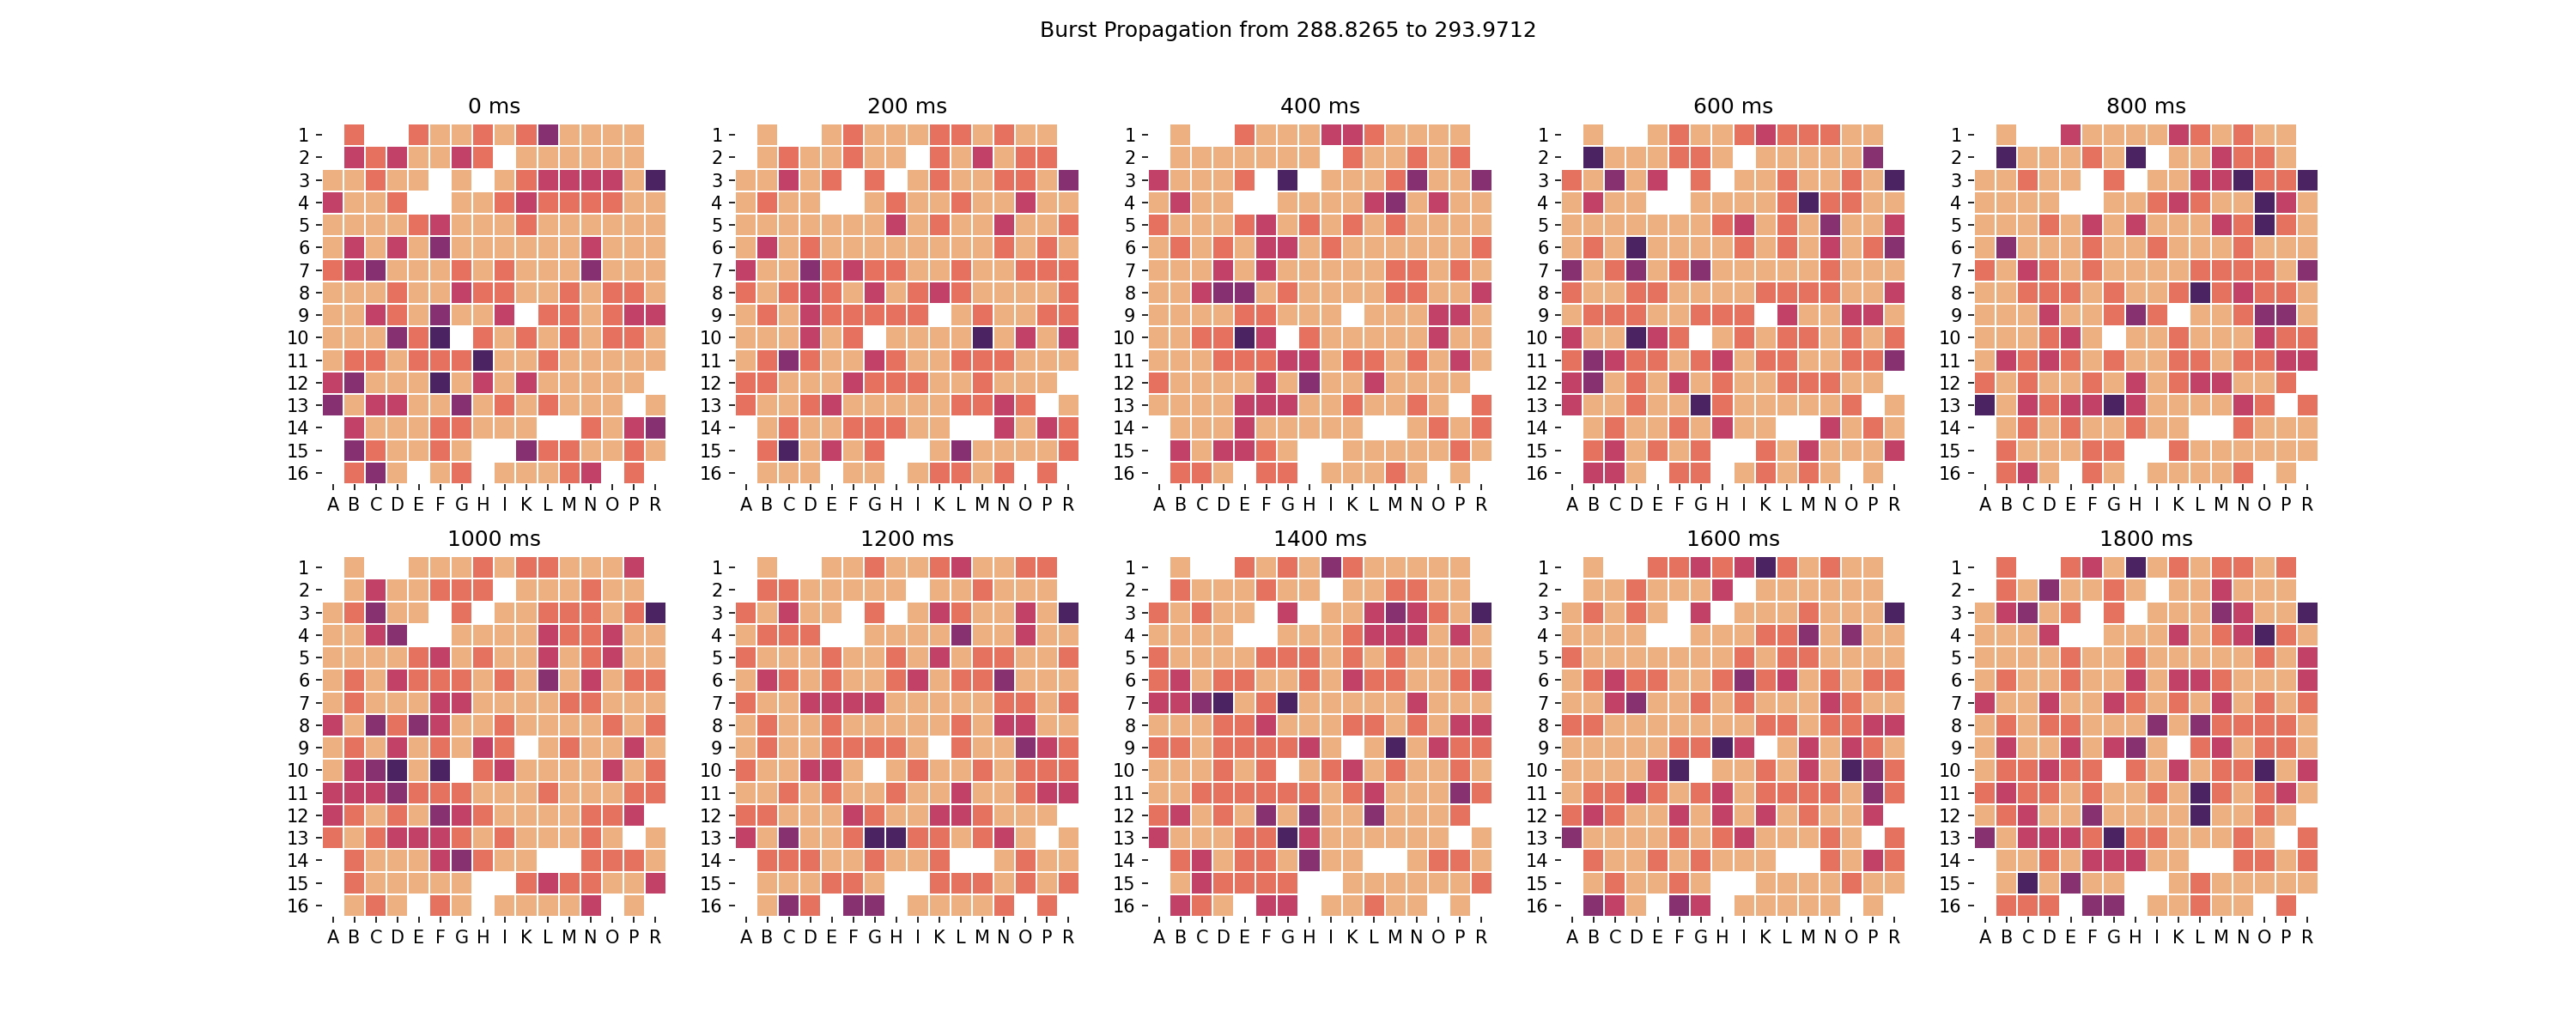

In [144]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    #plotframe_filled = plotframe_filled.fillna(0)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig(filename+'_divided_burst_spatial_09082021.png', dpi=300, bbox_inches = 'tight')



## we can try what happens if we zoom in further

In [75]:
b_of_interest_start = 39.2
b_of_interest_end = 39.6

<IPython.core.display.Javascript object>


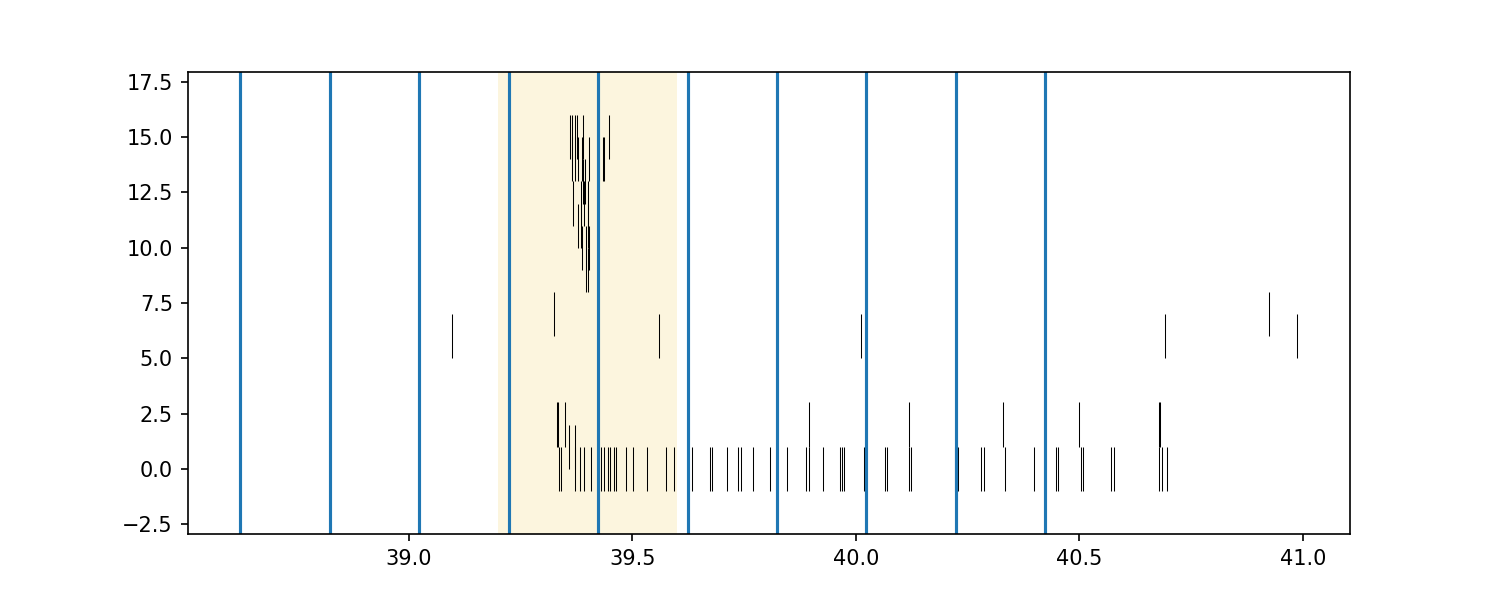

In [76]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_09082021_zooming.png', dpi=300, bbox_inches = 'tight')

In [77]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# let us make the heatmap window generic, so the burst is always subdivied into 10 subplots
observed_time = b_of_interest_end-b_of_interest_start

heatmap_window = observed_time/10 # in seconds

# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))

time_windows = time_windows[:10]

In [78]:
len(time_windows)

10

In [79]:
# we again obtain the array of that burst
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

In [80]:
b_of_interest_end

39.6

<IPython.core.display.Javascript object>


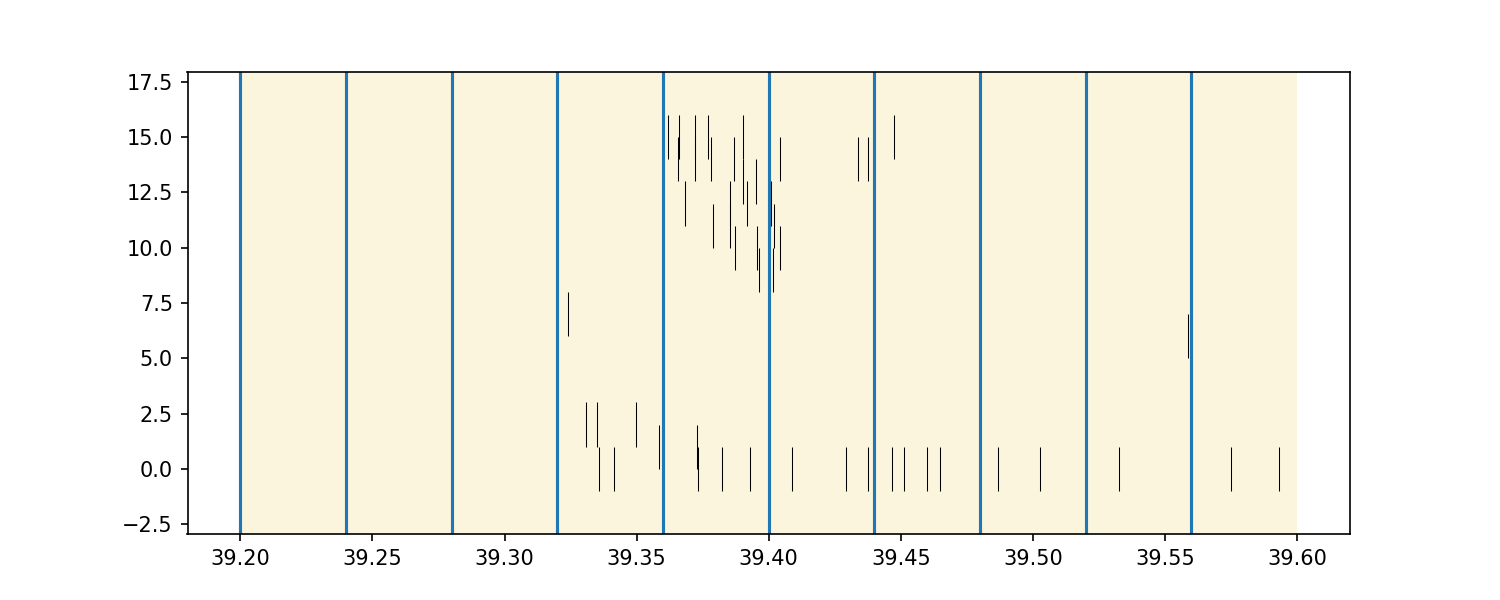

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')

In [82]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_MAD, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        

<IPython.core.display.Javascript object>


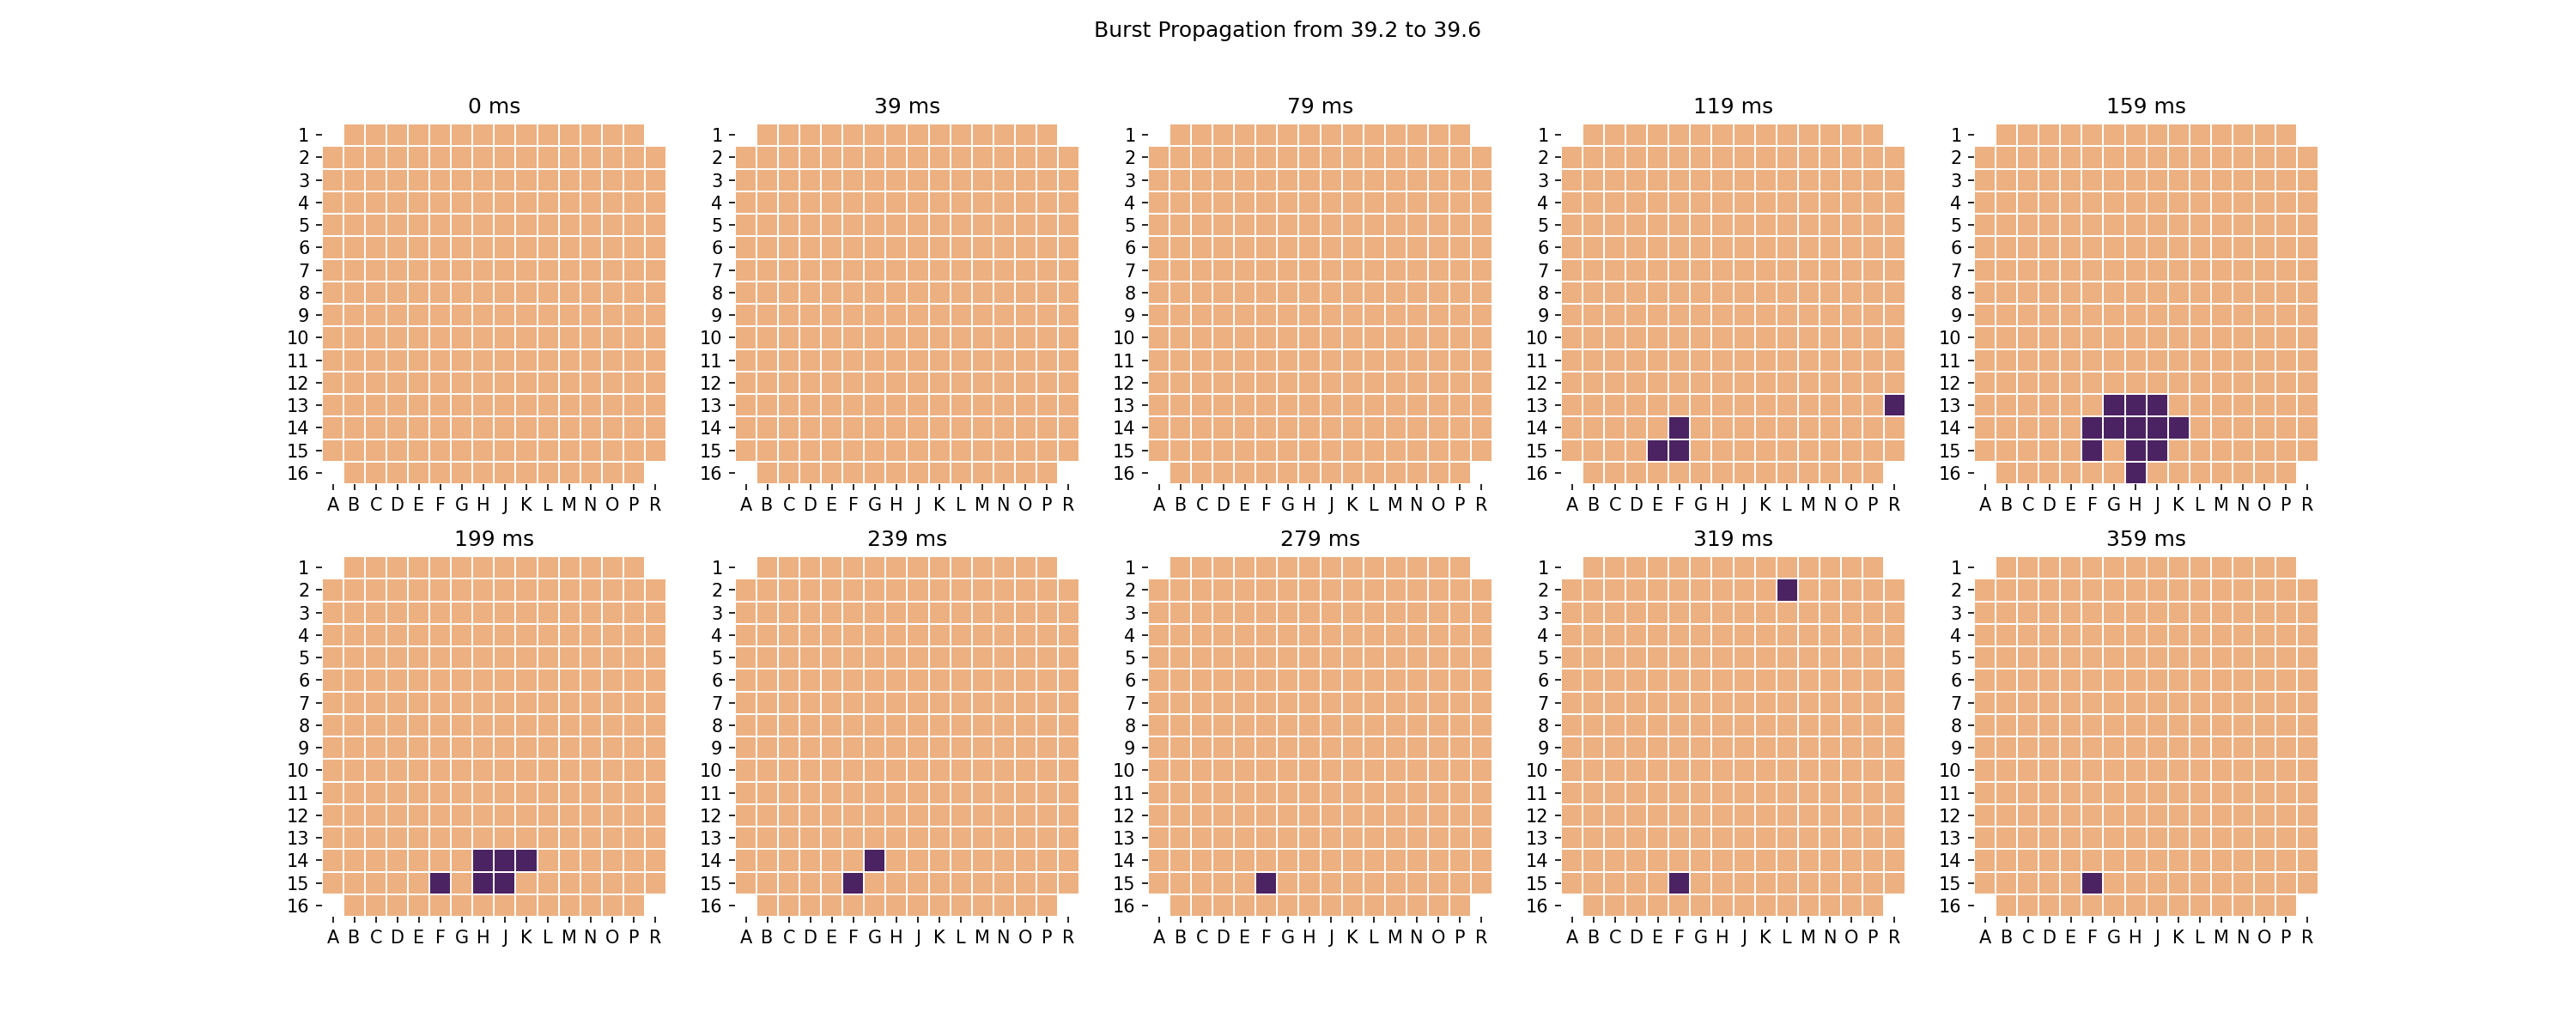

In [83]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig(filename +'_divided_burst_spatial_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')

In [ ]:
overview_df.loc['test']['filename']=2